In [57]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter
import os
from google.colab import drive
drive.mount('/content/gdrive')

# # Change working directory to be current folder
# # os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
# os.chdir('/content/gdrive/My Drive/xunfei_emotion_recognition')
# !ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
!pwd

/content


In [ ]:
!cp gdrive/MyDrive/xunfei_emotion_recognition/train.zip train_local
!cp gdrive/MyDrive/xunfei_emotion_recognition/test.zip train_local
!unzip train_local/test.zip
!unzip train_local/train.zipn

Archive:  train_local/test.zip
replace test/06796.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train_local/train.zip
replace train/happy/im4403.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [77]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

%matplotlib inline

print(tf.test.gpu_device_name())
print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

/device:GPU:0
Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [78]:
# basic setting
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


In [79]:
batch_size = 32
num_classes= 7
from keras.preprocessing.image import ImageDataGenerator
#data augument
train_datagen = ImageDataGenerator(rescale=1./255,
                                   # rotation_range=10,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   # horizontal_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_datagen.flow_from_directory('./train/', 
                                               color_mode='rgb',
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               target_size=(48, 48),
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory('./train/', 
                                           color_mode='rgb',
                                           batch_size=batch_size, 
                                           class_mode='categorical',
                                           target_size=(48, 48),
                                           shuffle=False,
                                           subset = 'validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# 新段落

In [80]:
optmz       = optimizers.Adam(lr=0.001)                                         # Step 1
modelname   = 'ResV1Cfg5'                                                # Step 2

                                                                                # Step 3
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):

    convLyr     = Conv2D(numFilters,
                         kernel_size=kernelSz,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4),
                         name=lyrName+'_conv' if lyrName else None)
    x           = inputs
    
    if convFirst:
        x       = convLyr(x)
        
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
            
        x       = convLyr(x)
    return x

                                                                                # Step 4
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    
    x       = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr  = str(run+1)
        
        if downsampleOnFirst and run == 0:
            strides     = 2
            
        y       = resLyr(inputs=x,
                         numFilters=numFilters,
                         strides=strides,
                         lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y       = resLyr(inputs=y,
                         numFilters=numFilters,
                         activation=None,
                         lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x   = resLyr(inputs=x,
                         numFilters=numFilters,
                         kernelSz=1,
                         strides=strides,
                         activation=None,
                         batchNorm=False,
                         lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x       = add([x,y],
                      name=names+'_Blk'+blkStr+'_add' if names else None)
        x       = Activation('relu',
                             name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
    return x
    
                                                                                # Step 5
def createResNetV1(inputShape=(48,48,3),
                   numClasses=7):
    inputs=Input(shape=inputShape)

    v=resLyr(inputs,lyrName='Inpt')
    v=resBlkV1(inputs=v,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=False,
             names='Stg1')
    
    v=resBlkV1(inputs=v,
             numFilters=32,
             numBlocks=3,
             downsampleOnFirst=True,
             names='Stg2')
    
    v=resBlkV1(inputs=v,
             numFilters=64,
             numBlocks=3,
             downsampleOnFirst=True,
             names='Stg3')
    v=Dropout(0.5)(v)
    
    v=AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v=Flatten()(v)
    outputs=Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(v)
    model=Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer=optmz,metrics=['accuracy'])
    return model

                                                                                # Step 6
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 48, 48, 16)   448         input_8[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 48, 48, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 48, 48, 16)   0           Inpt_bn[0][0]                    
____________________________________________________________________________________________

In [81]:
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3        
    elif epoch > 140:
        lr  *= 1e-3       
    elif epoch > 120:
        lr  *= 1e-2     
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

                                                                                # Step 2
folderpath      = '/content/gdrive/My Drive/xunfei_emotion_recognition/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger,LRScheduler]                           # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.hdf5
Path to log:   /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.csv


In [82]:
model.fit(train_data,
                  validation_data=val_data,
                    epochs=10,
                    verbose=1,
                  callbacks=callbacks_list)     

Epoch 1/10
Learning rate:  0.001
718/718 [==============================] - 20s 25ms/step - loss: 1.8939 - accuracy: 0.3312 - val_loss: 1.7419 - val_accuracy: 0.4212

Epoch 00001: val_accuracy improved from -inf to 0.42118, saving model to /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
Learning rate:  0.001
718/718 [==============================] - 13s 18ms/step - loss: 1.5645 - accuracy: 0.4600 - val_loss: 1.6477 - val_accuracy: 0.4381

Epoch 00002: val_accuracy improved from 0.42118 to 0.43808, saving model to /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.hdf5
Epoch 3/10
Learning rate:  0.001
718/718 [==============================] - 13s 18ms/step - loss: 1.4171 - accuracy: 0.5177 - val_loss: 1.4688 - val_accuracy: 0.5095

Epoch 00003: val_accuracy improved from 0.43808 to 0.50949, saving model to /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.hdf5
Epoch 4/10
Learning rate:  0.001
718/718 [==============================] - 13s 18ms/step - loss: 1.3279 - accuracy: 0.5574 - val_loss: 1.4023 - val_accuracy: 0.5299

Epoch 00004: val_accuracy improved from 0.50949 to 0.52987, saving model to /content/gdrive/My Drive/xunfei_emotion_recognition/ResV1Cfg5.hdf5
Epoch 5/10
Learning rate:  0.001
718/718 [============================

In [83]:
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(val_data)                                            # Step 2
print("Prediction completes.")

Prediction completes.


In [86]:
val_data = val_datagen.flow_from_directory('./train/', 
                                           color_mode='rgb',
                                           class_mode='binary',
                                           target_size=(48, 48),
                                           shuffle=False,
                                           subset = 'validation')
ylabel=[]
for i in range(0,len(val_data)):
  for j in range(0,len(val_data[i][1])):
    ylabel.append(val_data[i][1][j])
ylabel=np.array(ylabel)
print(ylabel.shape)

Found 5741 images belonging to 7 classes.
(5741,)


In [87]:
labelname   = ['angry', 'disgusted', 'fearful', 'happy','neutral', 'sad', 'surprised'] 
predout     = np.argmax(predicts,axis=1)                                                                           
testout     = ylabel
testScores  = metrics.accuracy_score(testout,predout)                          
 # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 57.25%
              precision    recall  f1-score   support

       angry     0.5279    0.3554    0.4248       799
   disgusted     0.6905    0.3333    0.4496        87
     fearful     0.4828    0.3260    0.3892       819
       happy     0.8236    0.7505    0.7854      1443
     neutral     0.4468    0.7190    0.5511       993
         sad     0.4422    0.5145    0.4756       966
   surprised     0.7233    0.6514    0.6855       634

    accuracy                         0.5725      5741
   macro avg     0.5910    0.5215    0.5373      5741
weighted avg     0.5914    0.5725    0.5699      5741



# 新段落

[[ 284    3   67   65  206  148   26]
 [  17   29    4    2   11   23    1]
 [  75    5  267   33  152  211   76]
 [  41    0   39 1083  168   82   30]
 [  32    2   34   60  714  141   10]
 [  68    2   58   40  286  497   15]
 [  21    1   84   32   61   22  413]]


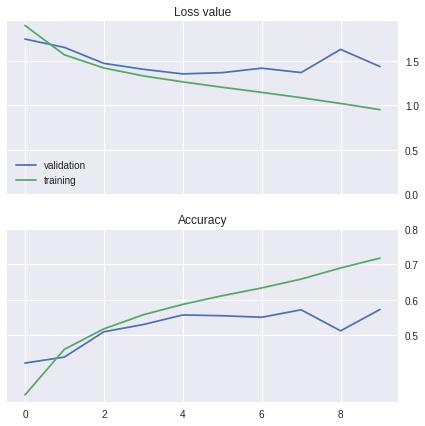

In [88]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

In [97]:
!cp -r test test2

In [98]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        './test2/',
        target_size=(48, 48),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        )

filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = nb_samples)

Found 7178 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [99]:
train_data.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [100]:
import numpy as np
import pandas as pd
cls_name = np.array(['angry', 'disgusted', 'fearful', 'happy','neutral', 'sad', 'surprised'])

In [101]:
submit_df = pd.DataFrame({'name': filenames, 'label': cls_name[predict.argmax(1)]})

In [102]:
submit_df.head()

,name,label
0,test/00001.png,surprised
1,test/00002.png,fearful
2,test/00003.png,angry
3,test/00004.png,happy
4,test/00005.png,surprised


In [103]:
submit_df = submit_df[submit_df['name'].apply(lambda x: 'test' in x )]
submit_df['name'] = submit_df['name'].apply(lambda x: x.split('/')[-1])

In [104]:
submit_df = submit_df.sort_values(by='name')
submit_df.to_csv('submit.csv', index=None)